In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
import numpy as np
import pickle
import torch
import matplotlib.pyplot as plt 
#from fase.core import heaan

from fase import HEAAN
from fase import HEAAN as he
from typing import List, Callable

from fase import hnrf as hnrf

from fase.hnrf.tree import NeuralTreeMaker
from fase.hnrf import heaan_nrf 
from fase.hnrf.hetree import HomomorphicModel 

#import importlib

from time import time

Using CPU version HEAAN


In [6]:
def decrypt_print(ctx, n=20):
    res1 = decrypt(secretKey, ctx)
    print(res1[:n])
    
def decrypt(secretKey, enc):
    featurized = scheme.decrypt(secretKey, enc)
    arr = np.zeros(n, dtype=np.complex128)
    featurized.__getarr__(arr)
    return arr.real

def encrypt(val):
    ctxt = he.Ciphertext()#logp, logq, n)
    vv = np.zeros(n) # Need to initialize to zero or will cause "unbound"
    vv[:len(val)] = val
    scheme.encrypt(ctxt, he.Double(vv), n, logp, logq)
    del vv
    return ctxt

from torch.utils import data

class TabularDataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, X: np.ndarray, y: np.ndarray):
        'Initialization'
        self.X, self.y = X,y

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.X)

    def __getitem__(self, index):
        'Generates one sample of data'

        # Load data and get label
        X = torch.tensor(self.X[index]).float()
        y = torch.tensor(self.y[index])

        return X, y

class Param():
    def __init__(self, n=None, logn=None, logp=None, logq=None, logQboot=None):
        self.n = n
        self.logn = logn
        self.logp = logp
        self.logq = logq 
        self.logQboot = logQboot
        if self.logn == None:
            self.logn = int(np.log2(n))
            
CAM_LIST= {1: "e",
           2: "e",
           3: "a",
           4: "e",
           5: "e",
           6: "e",
           7: "e",
           8: "a",
           9: "a",
           10:"e",
           11:"e",
           12:"e",
           13:"a",
           14:"e"}


# Train a RF model  -- smaller example


In [4]:
import fastai
#print(fastai.__version__)

from fastai.basic_data import DataBunch, DataLoader
#from fastai.tabular.data import TabularDataLoaders

from fastai.tabular.learner import Learner
from fastai.metrics import accuracy

from fase.hnrf.tree import CrossEntropyLabelSmoothing
import torch.nn as nn

matcher를 풀고 train하면 성능이 쉽게 올라가지만 중간에 계산값이 +/- 1을 넘어갈 가능성이 높아질 것 같음.  
근데 matcher 안 풀고는 좀처럼 성능이 올라가지 않음... 

In [14]:
#model_dir = "/home/hoseung/Dropbox/DeepInsight/2021ETRI/BBS_data/Frame8_models/"

model_dir = "/home/hoseung/Work/Kinect_BBS_demo/nbs/"

#for action in np.arange(1,15): 
# 3, 9는 아직 없음 , 12번 다시. 
action = 14
cam = CAM_LIST[action]

fn_model_out = f"trained_model_{action}_{cam}.pickle"
fn_data_out = f"BBS_dataset_{action}_{cam}.pickle"

fn_model = model_dir + fn_model_out
fn_dat = model_dir + fn_data_out

rf_model = pickle.load(open(fn_model, "rb"))

print("model's depth:", rf_model.max_depth)
print("model's tree count:", rf_model.n_estimators)


#####
dataset = pickle.load(open(fn_dat, "rb"))

X_train = dataset["train_x"]
y_train = dataset["train_y"]
X_valid = dataset["valid_x"]
y_valid = dataset["valid_y"]

print("min max of input dataset")
print(X_train.min(), X_train.max())
print(X_valid.min(), X_valid.max())

#####
from sklearn.tree import BaseDecisionTree
from fase.hnrf.tree import NeuralRF

dilatation_factor = 15
polynomial_degree = 31

estimators = rf_model.estimators_

my_tm_tanh = NeuralTreeMaker(torch.tanh, 
                            use_polynomial=True,
                            dilatation_factor=dilatation_factor, 
                            polynomial_degree=polynomial_degree)

Nmodel =NeuralRF(estimators, my_tm_tanh)

# NRF 성능 테스트
with torch.no_grad():
    neural_pred = Nmodel(torch.tensor(X_train).float()).argmax(dim=1).numpy()

pred = rf_model.predict(X_train)
print(f"Original accuracy : {(pred == y_train).mean()}")
print(f"Accuracy of tanh : {(neural_pred == y_train).mean()}")
print(f"Match between tanh and original : {(neural_pred == pred).mean()}")

model's depth: 7
model's tree count: 20
min max of input dataset
0.0 1.0000000000000002
0.0 1.0000000000000002
Original accuracy : 0.9737470167064439
Accuracy of tanh : 0.5091487669053302
Match between tanh and original : 0.522673031026253


model's depth: 7
model's tree count: 20
min max of input dataset
0.0 1.0000000000000002
0.0 1.0000000000000002
Original accuracy : 0.9737470167064439
Accuracy of tanh : 0.5091487669053302
Match between tanh and original : 0.522673031026253
torch.Size([241, 87, 20]) False
torch.Size([87, 20]) False
torch.Size([88, 87, 20]) False
torch.Size([88, 20]) False
torch.Size([5, 88, 20]) True
torch.Size([5, 20]) True


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


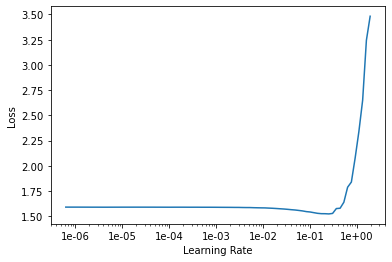

In [115]:
####
bs = 128

train_ds = TabularDataset(X_train, y_train)
valid_ds = TabularDataset(X_valid, y_valid)

train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs)
fix_dl = DataLoader(train_ds, batch_size=bs, shuffle=False)

Nmodel.freeze_layer("comparator")
Nmodel.freeze_layer("matcher")

for p in Nmodel.parameters():
    print(p.shape, p.requires_grad)

####
data = DataBunch(train_dl, valid_dl, fix_dl=fix_dl)
#data = TabularDataLoaders.from_dsets(train_dl, valid_dl, bs=64)

criterion = CrossEntropyLabelSmoothing()

learn = Learner(data, Nmodel, loss_func=criterion, metrics=accuracy)

#for i in range(5):
    #learn.lr_find()
    #learn.recorder.plot()

learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,1.518271,1.451471,0.479543,00:00
1,1.426746,1.324422,0.492158,00:00
2,1.346151,1.223834,0.563587,00:00
3,1.270850,1.134618,0.629901,00:00
4,1.210248,1.070825,0.686669,00:00
5,1.152480,1.059005,0.715138,00:00
6,1.110996,1.104388,0.659905,00:00
7,1.085097,1.036491,0.676100,00:00
8,1.081340,1.098816,0.665019,00:00
9,1.058971,0.999107,0.727924,00:00


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


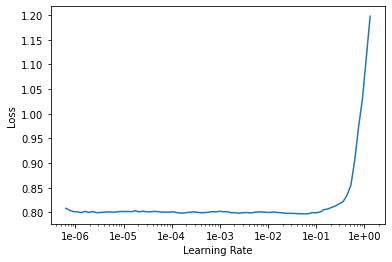

In [116]:
learn.fit_one_cycle(50, 0.3)

learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.801858,0.839077,0.840607,00:00
1,0.799508,0.838998,0.838902,00:00
2,0.799733,0.839840,0.834470,00:00
3,0.801639,0.845531,0.834640,00:00
4,0.803071,0.850359,0.827310,00:00
5,0.804322,0.842823,0.836856,00:00
6,0.804836,0.843482,0.841459,00:00
7,0.804371,0.838098,0.832765,00:00
8,0.804385,0.839817,0.825946,00:00
9,0.803356,0.840122,0.829867,00:00


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


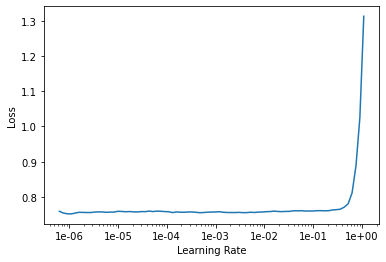

In [117]:
learn.fit_one_cycle(100, 0.1)
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.753475,0.798588,0.867201,00:00
1,0.755471,0.798668,0.868565,00:00
2,0.757168,0.799792,0.865496,00:00
3,0.758395,0.800932,0.864644,00:00
4,0.760505,0.802323,0.863962,00:00
5,0.759976,0.801932,0.863962,00:00
6,0.760215,0.803539,0.867371,00:00
7,0.761640,0.805042,0.857995,00:00
8,0.766143,0.808832,0.854074,00:00
9,0.764305,0.798752,0.866860,00:00


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


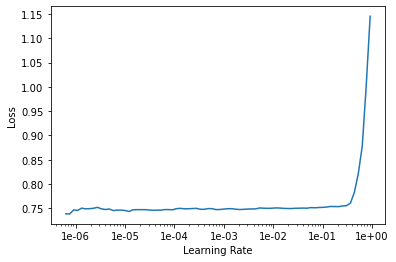

In [118]:
learn.fit_one_cycle(40, 0.02)
learn.lr_find()
learn.recorder.plot()

In [381]:
## Fine-tuned NRF model
pred = rf_model.predict(X_valid)

with torch.no_grad():
    neural_pred = Nmodel(torch.tensor(X_valid).float()).argmax(dim=1).numpy()

print(f"Original accuracy : {(pred == y_valid).mean()}")
print(f"Accuracy : {(neural_pred == y_valid).mean()}")
print(f"Same output : {(neural_pred == pred).mean()}")

from fase.hnrf.hetree import HNRF
h_rf = HNRF(Nmodel)
pickle.dump(Nmodel, open(f"Nmodel_{action}_{cam}.pickle", "wb"))
pickle.dump(h_rf, open(f"h_rf_{action}_{cam}.pickle", "wb"))
np.savetxt(f"comparator_{action}_{cam}.txt", h_rf.return_comparator(), fmt='%d', 
           header=f"{len(h_rf.return_comparator())}")

Original accuracy : 0.9135338345864662
Accuracy : 0.9319890635680109
Same output : 0.8925153793574846


In [386]:
pwd

'/home/hoseung/Work/Kinect_BBS_demo/nbs'

# Test

In [9]:
from fase.hnrf.hetree import HNRF
action = 1
cam = CAM_LIST[action]
Nmodel = pickle.load(open(f"Nmodel_{action}_{cam}.pickle", "rb"))
h_rf = HNRF(Nmodel)

In [10]:
logq = 540
logp = 30
logn = 14 # 질문 * Ntree
n = 1*2**logn
slots = n

parms = Param(n=n, logp=logp, logq=logq)

do_reduction=False

ring = he.Ring()
secretKey = he.SecretKey(ring)
scheme = he.Scheme(secretKey, ring, False)

algo = he.SchemeAlgo(scheme)

# reduction때는 right rotation N_class개 필요. 
if do_reduction:
    Nclass = Nmodel.head.shape[0]
    scheme.addLeftRotKeys(secretKey)
    for i in range(Nclass):
        scheme.addRightRotKey(secretKey, i+1) # 
else:
    # reduction 안 하면 하나짜리 rotation만 여러번 반복.
    scheme.addLeftRotKey(secretKey, 1)

In [11]:
from fase.core import commonAlgo
class HETreeEvaluator:
    """Evaluator which will perform homomorphic computation"""

    def __init__(self, 
                 b0: np.ndarray, w1, b1, w2, b2,
                 scheme,
                 parms,
                 activation_coeffs: List[float], 
                 #polynomial_evaluator: Callable,
                 
                 #relin_keys: seal.RelinKeys, galois_keys: seal.GaloisKeys, scale: float,
                 do_reduction=True):
        """Initializes with the weights used during computation.

        Args:
            b0: bias of the comparison step

        """
        self.sk = secretKey ######### 
        self.scheme = scheme
        self.algo = he.SchemeAlgo(scheme)
        self.commonAlgo = commonAlgo.CommonAlgorithms(scheme, "HEAAN")
        # scheme should hold all keys
        self.parms = parms
        
        self._activation_coeff = activation_coeffs
        self._activation_poly_degree = len(activation_coeffs) -1
        self.do_reduction = do_reduction

        # 10-degree activation -> up to 5 multiplications 
        logq_w1 = self.parms.logq - 5 * self.parms.logp
        logq_b1 = logq_w1 - self.parms.logp
        logq_b2 = logq_b1 - 5*self.parms.logp

        self.b0_ctx = self.encrypt(b0)
        self.w1 = [self.to_double(w) for w in w1]
        self.w2 = [self.to_double(w) for w in w2]
        
        self.b1_ctx = self.encrypt(b1, logq=logq_b1)
        self.b2_ctx = [self.encrypt(b, logq=logq_b2) for b in b2]

        self.setup_summary()      
    
    def setup_summary(self):
        print("CKKS paramters:")
        print("---------------------------")
        print(f"n = {self.parms.n}")
        print(f"logp = {self.parms.logp}")
        print(f"logq = {self.parms.logq}")
        print(f"tanh activation polynomial coeffs = {self._activation_coeff}")
        print(f"tanh activation polynomial degree = {self._activation_poly_degree}")
        
        print("\nNeural RF")
        print("---------------------------")
        print(f"")
    
    def heaan_double(self, val):
        mvec = np.zeros(self.parms.n)
        mvec[:len(val)] = np.array(val)
        return he.Double(mvec)

    def decrypt_print(self, ctx, n=20):
        res1 = self.decrypt(ctx)
        print("_____________________")
        print(res1[:n])
        print(res1.min(), res1.max())
        print("---------------------")

    def decrypt(self, enc):
        temp = self.scheme.decrypt(self.sk, enc)
        arr = np.zeros(self.parms.n, dtype=np.complex128)
        temp.__getarr__(arr)
        return arr.real
        
    def encrypt_ravel(self, val, **kwargs):
        """encrypt a list
        """
        return self.encrypt(np.array(val).ravel(), **kwargs)

    def encrypt(self, val, n=None, logp=None, logq=None):
        if n == None: n = self.parms.n
        if logp == None: logp = self.parms.logp
        if logq == None: logq = self.parms.logq
            
        ctxt = he.Ciphertext()
        vv = np.zeros(n) # Need to initialize to zero or will cause "unbound"
        vv[:len(val)] = val
        self.scheme.encrypt(ctxt, he.Double(vv), n, logp, logq)
        del vv
        return ctxt
    
    def to_double(self, val):
        n = self.parms.n
        vv = np.zeros(n) # Need to initialize to zero or will cause "unbound"
        vv[:len(val)] = val
        return he.Double(vv)
        
        
    def activation(self, ctx):
        output = he.Ciphertext()
        output = he.Ciphertext()
        self.algo.function_poly(output, 
                    ctx, 
                    he.Double(self._activation_coeff), 
                    self.parms.logp, 
                    self._activation_poly_degree)
        return output        
        

    def __call__(self, ctx):
        # First we add the first bias to do the comparisons
        ctx = self.compare(ctx)
        print("After compare")
        self.decrypt_print(ctx)
        ctx = self.match(ctx)
        print("after match")
        self.decrypt_print(ctx)
        outputs = self.decide(ctx)
        if self.do_reduction:
            outputs = self.reduce(outputs)

        return outputs

    def compare(self, ctx, debug=False):
        """Calculate first layer of the HNRF
        
        ctx = featurizer.encrypt(x)
        
        Assuming n, logp, logq are globally available
        
        """
        b0_ctx = self.b0_ctx
        self.scheme.addAndEqual(ctx, b0_ctx)
        # Activation
        output = self.activation(ctx)
            
        del b0_ctx, ctx

        return output
    
    def _mat_mult(self, diagonals, ctx):
        """
        Take plain vector 
        """
        scheme = self.scheme
        n = self.parms.n
        logp = self.parms.logp
        #logq = self.parms.logq

        ctx_copy = he.Ciphertext()
        ctx_copy.copy(ctx)
        
        for i, diagonal in enumerate(diagonals):
            if i > 0: scheme.leftRotateFastAndEqual(ctx_copy, 1) # r = 1

            # Multiply with diagonal
            dd = he.Ciphertext()
            
            # Reduce the scale of diagonal
            scheme.multByConstVec(dd, ctx_copy, diagonal, logp)
            scheme.reScaleByAndEqual(dd, logp)
            
            if i == 0:
                mvec = np.zeros(n)
                temp = he.Ciphertext()
                scheme.encrypt(temp, he.Double(mvec), n, logp, ctx_copy.logq - logp)
            
            # match scale 
            scheme.addAndEqual(temp, dd)

            #print("temp",i)
            #self.decrypt_print(temp,10)
            
            del dd
        del ctx_copy
        return temp


    def match(self, ctx):
        """Applies matching homomorphically.

        First it does the matrix multiplication with diagonals, then activate it.
        """
        output = self._mat_mult(self.w1, ctx)

        #print(f"MATCH:: 'output.logq', {output.logq} == {self.b1_ctx.logq}?")
        self.scheme.addAndEqual(output, self.b1_ctx)
        
        output = self.activation(output)
        return output

    def decide(self, ctx):
        """Applies the decisions homomorphically.

        For each class, multiply the ciphertext with the corresponding weight of that class and
        add the bias afterwards.
        """
        # ww와 bb도 미리 modDowntoAndEqual 가능 
        outputs = []

        for ww, bb in zip(self.w2, self.b2_ctx):
            output = he.Ciphertext()
            
            # Multiply weights            
            scheme.multByConstVec(output, ctx, ww, ctx.logp)
            #print("ctx", ctx)
            #print("bb", bb)
            self.scheme.reScaleByAndEqual(output, ctx.logp)
            
            # Add bias
            self.scheme.addAndEqual(output, bb)
            
            outputs.append(output)
        return outputs

    def _sum_reduce(self, ctx, logn, scheme):
        """
        return sum of a Ciphertext (repeated nslot times)
        
        example
        -------
        sum_reduct([1,2,3,4,5])
        >> [15,15,15,15,15]
        """
        output = he.Ciphertext()
        
        for i in range(logn):
            
            if i == 0:
                temp = he.Ciphertext(ctx.logp, ctx.logq, ctx.n)
                
                scheme.leftRotateFast(temp, ctx, 2**i)
                scheme.add(output, ctx, temp)
            else:
                scheme.leftRotateFast(temp, output, 2**i)
                scheme.addAndEqual(output, temp)
        return output


    def reduce(self, outputs):
        logp = self.parms.logp
        scheme = self.scheme

        for i, output in enumerate(outputs):
            output = self._sum_reduce(output, self.parms.logn, self.scheme)

            mask = np.zeros(self.parms.n)
            mask[0] = 1
            mask_hedb = he.ComplexDouble(mask)
            if i == 0:
                scores = he.Ciphertext()
                scheme.multByConstVec(scores, output, mask_hedb, logp)
                scheme.reScaleByAndEqual(scores, logp)
            else:
                temp = he.Ciphertext()
                scheme.multByConstVec(temp, output, mask_hedb, logp)
                scheme.reScaleByAndEqual(temp, logp)
                scheme.rightRotateFastAndEqual(temp, i)
                scheme.addAndEqual(scores, temp)

        return scores


    @classmethod
    def from_model(cls, model,
                   scheme,
                   parms,
                   activation_coeffs: List[float],
                   do_reduction=False):
        """Creates an Homomorphic Tree Evaluator from a model, i.e a neural tree or
        a neural random forest. """
        b0, w1, b1, w2, b2 = model.return_weights()

        return cls(b0, w1, b1, w2, b2, scheme, parms, activation_coeffs, do_reduction)


## To do
1. mat_mult만 따로 떼서 새 버전과 비교
2. 여러개의 DT가 어떻게 하나의 weight로 합쳐지는지 이해
3. 하나의 DT를 하나의 W로 두고 마지막에 합치는 방법 고려
4. 최대 가능 

In [15]:
t0 = time()
nrf_evaluator = HETreeEvaluator.from_model(h_rf,
                                            scheme,
                                            parms,
                                            my_tm_tanh.coeffs,
                                            do_reduction = do_reduction
                                            )
print(f"{time() - t0} seconds")

CKKS paramters:
---------------------------
n = 16384
logp = 30
logq = 540
tanh activation polynomial coeffs = [-2.220446e-16  1.414345e+01  6.957629e-14 -6.083490e+02 -4.696993e-12  1.686577e+04  1.302394e-10 -2.740924e+05
 -1.925923e-09  2.801868e+06  1.733859e-08 -1.913169e+07 -1.026167e-07  9.105737e+07  4.185374e-07 -3.108234e+08
 -1.210472e-06  7.742619e+08  2.519760e-06 -1.418430e+09 -3.787154e-06  1.907839e+09  4.071917e-06 -1.860355e+09
 -3.053341e-06  1.278950e+09  1.516193e-06 -5.875175e+08 -4.479662e-07  1.618027e+08  5.960464e-08 -2.019733e+07]
tanh activation polynomial degree = 31

Neural RF
---------------------------

10.060018062591553 seconds


이거를 빨리... 

In [16]:
featurizer = heaan_nrf.HETreeFeaturizer(h_rf.return_comparator(), scheme, parms)

In [17]:
for xx, yy in zip(X_valid[:4], y_valid[:4]):
    t0 = time()
    #print(len(xx))
    ctx = featurizer.encrypt(xx)
    result = nrf_evaluator(ctx)
    #print(f"Took {time() - t0:.2f} seconds")

    pred = []
    for res in result:
        dec = decrypt(secretKey, res)
        pred.append(np.sum(dec))

    print(f"Prediction: {np.argmax(pred)} == {yy}?") 
    neural_pred = Nmodel(torch.tensor(X_train[:1]).float())
    print(pred)
    print(neural_pred)
    print(f"{time() - t0} seconds")

After compare
_____________________
[-3553.537785   633.312096   986.104281  -787.331721   753.215784    17.463915  2229.890549  -523.92082    928.679984
   485.509195 -1378.30313     90.998323    77.088115   -61.983928   -28.754441  2653.945035  -150.272121   963.285134
  -841.769644   127.686831]
-5333.147424207689 5691.436050251888
---------------------
after match
_____________________
[ 7.852005e+37 -1.294581e+38  2.877582e+36 -3.370628e+37 -4.385838e+37 -2.508176e+37 -7.089489e+37  3.428295e+37
 -4.342916e+36 -6.037652e+37 -5.534335e+36  6.614096e+37 -3.197613e+37  1.451282e+37  2.682505e+37  1.911827e+37
  5.009485e+36  9.673895e+36 -6.125014e+37  3.132460e+37]
-1.8520879702038686e+38 1.9058639152915016e+38
---------------------
Prediction: 4 == 1?
[-3.71161233210469e+30, 9.307488528757506e+29, -3.2933943702326227e+30, -9.905789000637382e+30, 6.252425452385588e+30]
tensor([[0.3209, 0.2572, 0.2426, 0.2234, 0.2107]], grad_fn=<AddBackward0>)
320.9232385158539 seconds
After compare


In [36]:
xx.max()

0.9887150053714814

In [40]:
neural_pred = Nmodel(torch.tensor(X_train[:1]).float())
#Nmodel(torch.tensor(X_valid[:1]))

In [41]:
neural_pred

tensor([[   -68.3079,  -4021.2930, -13188.7412,  24814.9121, -10345.2754]],
       grad_fn=<AddBackward0>)

여기서 만든 h_rf와 새로 만든 h_rf의 모양, 값 차이 비교

min = 0, 
max = 1인데.. 왜 -1보다 작아질까...? 

In [23]:
pred

[1354.7771911621098,
 -657.0239105224605,
 -13200.904769897461,
 19254.122360229492,
 -9825.276138305662]